In [296]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import mean_absolute_error

# 最大表示列数の指定（ここでは50列を指定）
pd.set_option("display.max_columns", 1000)
pd.set_option("display.max_rows", 1000)

import warnings
warnings.filterwarnings("ignore")

In [297]:
path = "../input/"

train = pd.read_csv(path + "train.csv")
train_x = train.drop(["winPlacePerc"], axis=1)
train_y = train["winPlacePerc"]
test_x = pd.read_csv(path + "test.csv")

In [298]:
df = pd.concat([train_x, test_x])

In [299]:
print("訓練データのデータ数は{}、変数は{}種類です。".format(train.shape[0], train.shape[1]))
print("テストデータのデータ数は{}、変数は{}種類です".format(test_x.shape[0], test_x.shape[1]))

訓練データのデータ数は7134、変数は29種類です。
テストデータのデータ数は1794、変数は28種類です


In [300]:
len(train_x)

7134

In [301]:
len(test_x)

1794

## 特徴量

In [302]:
# killsとdamageDealtの標準化
df['playersJoined'] = df.groupby('matchId')['matchId'].transform('count')

df['killsNorm'] = df['kills']*((100-df['playersJoined'])/100 + 1)
df['damageDealtNorm'] = df['damageDealt']*((100-df['playersJoined'])/100 + 1)

df['killsPerWalkDistance'] = df['kills']/(df['walkDistance']+1) #The +1 is to avoid infinity, because there are entries where kills>0 and walkDistance=0. Strange.
df['killsPerWalkDistance'].fillna(0, inplace=True)

df.drop(['kills', 'damageDealt'], axis=1, inplace=True)

In [303]:
# boostsとhealsの標準化
df['boostsPerWalkDistance'] = df['boosts']/(df['walkDistance']+1) #The +1 is to avoid infinity, because there are entries where boosts>0 and walkDistance=0. Strange.
df['boostsPerWalkDistance'].fillna(0, inplace=True)
df['healsPerWalkDistance'] = df['heals']/(df['walkDistance']+1) #The +1 is to avoid infinity, because there are entries where heals>0 and walkDistance=0. Strange.
df['healsPerWalkDistance'].fillna(0, inplace=True)

df.drop(['boosts', 'heals'], axis=1, inplace=True)

### groupIdの前処理

In [304]:
group_count = df.groupby("groupId", as_index=False)["Id"].count().rename(columns={"Id": "TeamSize"})

df = pd.merge(df, group_count, on="groupId", how="left")

df.drop("groupId", axis=1, inplace=True)

train_x = df[:7134]
test_x = df[7134:]

### matchTypeの前処理
hot one encordingで処理

In [305]:
train["matchType"].unique()

array(['duo', 'duo-fpp', 'squad-fpp', 'solo-fpp', 'squad', 'crashfpp',
       'solo'], dtype=object)

In [306]:
matchType = pd.concat([train_x["matchType"], test_x["matchType"]])
matchType_ohe = pd.get_dummies(matchType)

matchType_ohe_train = matchType_ohe[:7134]
matchType_ohe_test = matchType_ohe[7134:]

train_x = pd.concat([train_x, matchType_ohe_train], axis=1)
test_x = pd.concat([test_x, matchType_ohe_test], axis=1)

train_x.drop("matchType", axis=1, inplace=True)
test_x.drop("matchType", axis=1, inplace=True)

train_x.head()

,Id,matchId,assists,DBNOs,headshotKills,killPlace,killPoints,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,playersJoined,killsNorm,damageDealtNorm,killsPerWalkDistance,boostsPerWalkDistance,healsPerWalkDistance,TeamSize,crashfpp,duo,duo-fpp,normal-squad-fpp,solo,solo-fpp,squad,squad-fpp
0,2860d3f9ee4d4b,25ade93a241f39,0,0,0,80,0,0,0.00,1413,48,48,1496,0,0.0,0,0.0,0,0,257.0,4,0,96,0.00,0.000,0.000000,0.000000,0.0,2,0,1,0,0,0,0,0,0
1,0b88c47e54cdcc,95125f5e05c653,0,4,0,5,1387,2,35.70,1386,48,47,-1,1,262.7,0,0.0,0,0,1025.0,5,1607,96,4.16,373.360,0.003899,0.001949,0.0,2,0,0,1,0,0,0,0,0
2,8f086d61515bc4,8a84da96d077c3,0,1,0,15,1673,1,27.39,1410,49,48,-1,0,0.0,0,0.0,0,0,712.8,2,1736,95,2.10,234.675,0.002802,0.000000,0.0,2,0,0,1,0,0,0,0,0
3,7c037ca62a38a4,a139eac809980a,0,0,0,50,1479,0,0.00,1357,31,28,-1,0,0.0,0,0.0,0,0,2738.0,4,1476,99,0.00,129.381,0.000000,0.000000,0.0,4,0,0,0,0,0,0,0,1
4,82f08cde238c60,e9d203a36b1d0a,0,2,0,36,0,1,25.75,1395,28,28,1479,0,0.0,0,0.0,0,0,129.4,2,0,100,1.00,200.000,0.007669,0.000000,0.0,4,0,0,0,0,0,0,0,1


### matchIdの前処理
削除

In [307]:
train_x.drop("matchId", axis=1, inplace=True)
test_x.drop("matchId", axis=1, inplace=True)

Idの前処理

In [308]:
train_x.drop("Id", axis=1, inplace=True)
test_x.drop("Id", axis=1, inplace=True)

### バリデーション

In [309]:
# 学習データを学習データとバリデーションデータに分ける
from sklearn.model_selection import KFold

kf = KFold(n_splits=4, shuffle=True, random_state=71)
tr_idx, va_idx = list(kf.split(train_x))[0]
tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

In [310]:
# custom function to run light gbm model
def run_lgb(train_X, train_y, val_X, val_y, x_test):
    params = {"objective" : "regression", 
              "metric" : "mae", 
              "n_estimators":20000, 
              "early_stopping_rounds":200,
              "num_leaves" : 31, 
              "learning_rate" : 0.05, 
              "bagging_fraction" : 0.7,
              "bagging_seed" : 0, 
              "num_threads" : 4,
              "colsample_bytree" : 0.7
             }
    
    lgtrain = lgb.Dataset(tr_x, tr_y)
    lgval = lgb.Dataset(va_x, va_y)
    model = lgb.train(params, lgtrain, 
                      valid_sets=[lgtrain, lgval], 
                      early_stopping_rounds=200, 
                      verbose_eval=1000)
    
    pred_test_y = model.predict(x_test, num_iteration=model.best_iteration)
    return pred_test_y, model

# Training the model #
pred_test, model = run_lgb(tr_x, tr_y, va_x, va_y, test_x)

Training until validation scores don't improve for 200 rounds
[1000]	training's l1: 0.0131845	valid_1's l1: 0.0453857
[2000]	training's l1: 0.00601502	valid_1's l1: 0.0446742
[3000]	training's l1: 0.00321347	valid_1's l1: 0.0444618
Early stopping, best iteration is:
[3459]	training's l1: 0.00245073	valid_1's l1: 0.0444306


In [311]:
# バリデーションデータでのスコアの確認
va_pred = model.predict(va_x)
score = mean_absolute_error(va_y, va_pred)
score

0.04443055186070956

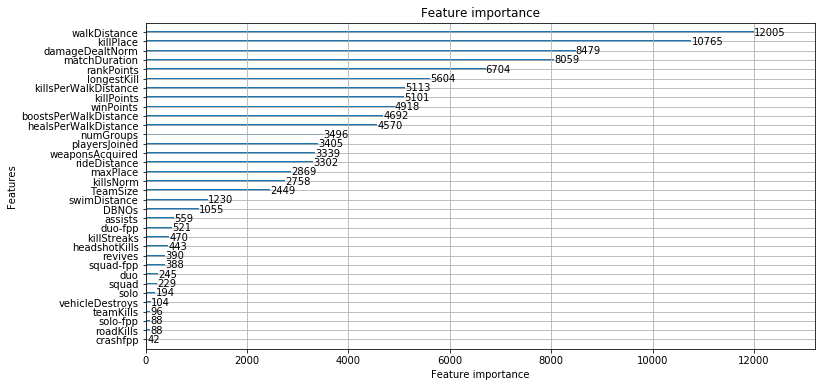

In [312]:
# 特徴量の重要度をプロットする
lgb.plot_importance(model, figsize=(12, 6))
plt.show()

In [313]:
# 予測
pred = model.predict(test_x)

In [314]:
path = "../submission/"

submission = pd.read_csv(path + "submission.csv")

submission["winPlacePerc"] = pred
submission

,winPlacePerc
0,0.134452
1,0.224600
2,0.254473
3,0.394788
4,0.536097
5,0.222428
6,0.100163
7,0.029401
8,0.554975
9,0.396896


In [315]:
submission.to_csv(path + "submission.csv", index=False)